# LightGBM Delay Forecasting

LightGBM on the same 63 features as XGBoost. Optuna-tuned (50 trials) for a fair comparison.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import lightgbm as lgb

from src.evaluation.metrics import calculate_delay_metrics
from src.config import TRAIN_END, VAL_END, TEST_START
from src.config import TABULAR_FEATURES

## Load Data

In [2]:
df = pd.read_csv('../data/processed/features.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['route', 'date']).reset_index(drop=True)

print(f'Total samples: {len(df):,}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Routes: {df["route"].nunique()}')

Total samples: 118,650
Date range: 2019-01-01 00:00:00 to 2025-06-30 00:00:00
Routes: 50


## Feature Selection

Same 63 features as XGBoost (`TABULAR_FEATURES`). Keeping features identical so the only difference is the algorithm itself.

Hyperparameters are Optuna-tuned (50 trials):
- `n_estimators=550`, `num_leaves=123`, `learning_rate=0.022`
- `subsample=0.76`, `colsample_bytree=0.86`, `min_child_samples=10`
- `reg_alpha=4e-6`, `reg_lambda=7.99`

In [3]:
# filter to features that actually exist in the dataset
available_features = [c for c in TABULAR_FEATURES if c in df.columns]
target_col = 'avg_arr_delay'

print(f'Using {len(available_features)} features for LightGBM (same tabular set as XGBoost)')
print(f'Target: {target_col}')

Using 63 features for LightGBM (same tabular set as XGBoost)
Target: avg_arr_delay


## Train/Test Split

In [4]:
# chronological split, same cutoffs as XGBoost
train_df = df[df['date'] < TRAIN_END].dropna(subset=available_features + [target_col])
val_df = df[(df['date'] >= TRAIN_END) & (df['date'] < VAL_END)].dropna(subset=available_features + [target_col])
test_df = df[df['date'] >= TEST_START].dropna(subset=available_features + [target_col])

X_train = train_df[available_features].values
y_train = train_df[target_col].values

X_val = val_df[available_features].values
y_val = val_df[target_col].values

X_test = test_df[available_features].values
y_test = test_df[target_col].values

print(f'Training samples: {len(X_train):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'Test samples: {len(X_test):,}')
print(f'Train period: {train_df["date"].min()} to {train_df["date"].max()}')
print(f'Val period: {val_df["date"].min()} to {val_df["date"].max()}')
print(f'Test period: {test_df["date"].min()} to {test_df["date"].max()}')

Training samples: 91,300
Validation samples: 9,100
Test samples: 18,250
Train period: 2019-01-01 00:00:00 to 2023-12-31 00:00:00
Val period: 2024-01-01 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-01 00:00:00 to 2025-06-30 00:00:00


## Load Trained Model

Trained with `src/training/train/train_lightgbm.py`.

In [5]:
model = joblib.load('../trained_models/lightgbm_delay.pkl')
print(f'Loaded LightGBM model (best iteration: {model.best_iteration_})')

Loaded LightGBM model (best iteration: 255)


## Evaluate on Test Set

In [6]:
# run forecasts and print metrics
y_pred = model.predict(test_df[available_features])

metrics = calculate_delay_metrics(y_test, y_pred)

print('\nLightGBM Test Set Metrics (Delay Forecasting):')
print(f'  MAE:              {metrics["mae"]:.2f} min')
print(f'  RMSE:             {metrics["rmse"]:.2f} min')
print(f'  Within 15min:     {metrics["within_15"]:.1f}%')
print(f'  Delay Detection:  {metrics["threshold_acc"]:.1f}%')
print(f'  R\u00b2:               {metrics["r2"]:.3f}')


LightGBM Test Set Metrics (Delay Forecasting):
  MAE:              11.22 min
  RMSE:             19.19 min
  Within 15min:     78.5%
  Delay Detection:  83.9%
  R²:               0.328


## XGBoost vs LightGBM Comparison

In [7]:
# compute baselines on the same test set for a fair comparison
naive_preds = test_df.groupby('route').apply(
    lambda x: x[target_col].shift(1), include_groups=False
).droplevel(0).dropna()

naive_targets = test_df.loc[naive_preds.index, target_col]
naive_metrics = calculate_delay_metrics(naive_targets.values, naive_preds.values)

rolling_preds = test_df.groupby('route').apply(
    lambda x: x[target_col].shift(1).rolling(7, min_periods=1).mean(), include_groups=False
).droplevel(0).dropna()

rolling_targets = test_df.loc[rolling_preds.index, target_col]
rolling_metrics = calculate_delay_metrics(rolling_targets.values, rolling_preds.values)

# load XGBoost to compare head-to-head on the exact same data
xgb_model = joblib.load('../trained_models/xgboost_delay.pkl')
xgb_preds = xgb_model.predict(test_df[available_features])
xgb_metrics = calculate_delay_metrics(y_test, xgb_preds)

comparison = pd.DataFrame([
    {'Model': 'Naive (last value)', 'MAE (min)': naive_metrics['mae'], 'RMSE (min)': naive_metrics['rmse'], 'Within 15min (%)': naive_metrics['within_15'], 'R\u00b2': naive_metrics['r2']},
    {'Model': 'Rolling Mean (7-day)', 'MAE (min)': rolling_metrics['mae'], 'RMSE (min)': rolling_metrics['rmse'], 'Within 15min (%)': rolling_metrics['within_15'], 'R\u00b2': rolling_metrics['r2']},
    {'Model': f'XGBoost ({len(available_features)} features)', 'MAE (min)': xgb_metrics['mae'], 'RMSE (min)': xgb_metrics['rmse'], 'Within 15min (%)': xgb_metrics['within_15'], 'R\u00b2': xgb_metrics['r2']},
    {'Model': f'LightGBM ({len(available_features)} features)', 'MAE (min)': metrics['mae'], 'RMSE (min)': metrics['rmse'], 'Within 15min (%)': metrics['within_15'], 'R\u00b2': metrics['r2']},
]).set_index('Model').round(2)

lgb_vs_naive = (naive_metrics['mae'] - metrics['mae']) / naive_metrics['mae'] * 100
lgb_vs_rolling = (rolling_metrics['mae'] - metrics['mae']) / rolling_metrics['mae'] * 100
lgb_vs_xgb = (xgb_metrics['mae'] - metrics['mae']) / xgb_metrics['mae'] * 100

print('Model Comparison on Test Set:')
print(f'LightGBM improvement over naive:        {lgb_vs_naive:.1f}%')
print(f'LightGBM improvement over rolling mean:  {lgb_vs_rolling:.1f}%')
print(f'LightGBM improvement over XGBoost:       {lgb_vs_xgb:.1f}%')
comparison

Model Comparison on Test Set:
LightGBM improvement over naive:        26.2%
LightGBM improvement over rolling mean:  19.5%
LightGBM improvement over XGBoost:       -0.1%


,MAE (min),RMSE (min),Within 15min (%),R²
Model,,,,
Naive (last value),15.19,25.60,67.71,-0.19
Rolling Mean (7-day),13.93,22.63,69.49,0.07
XGBoost (63 features),11.21,19.22,78.67,0.33
LightGBM (63 features),11.22,19.19,78.48,0.33


## Feature Importance

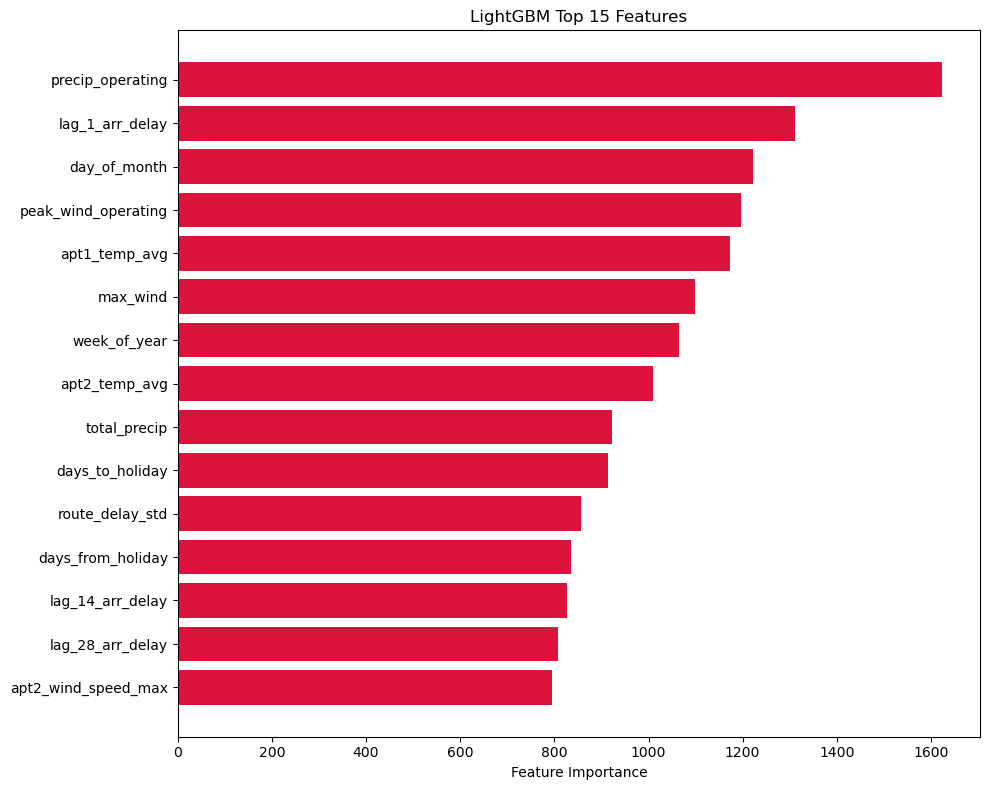

In [8]:
# see which features LightGBM relies on most
importance_df = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
top_features = importance_df.tail(15)
ax.barh(top_features['feature'], top_features['importance'], color='crimson')
ax.set_xlabel('Feature Importance')
ax.set_title('LightGBM Top 15 Features')
plt.tight_layout()
plt.show()

## Forecast vs Actual Plot

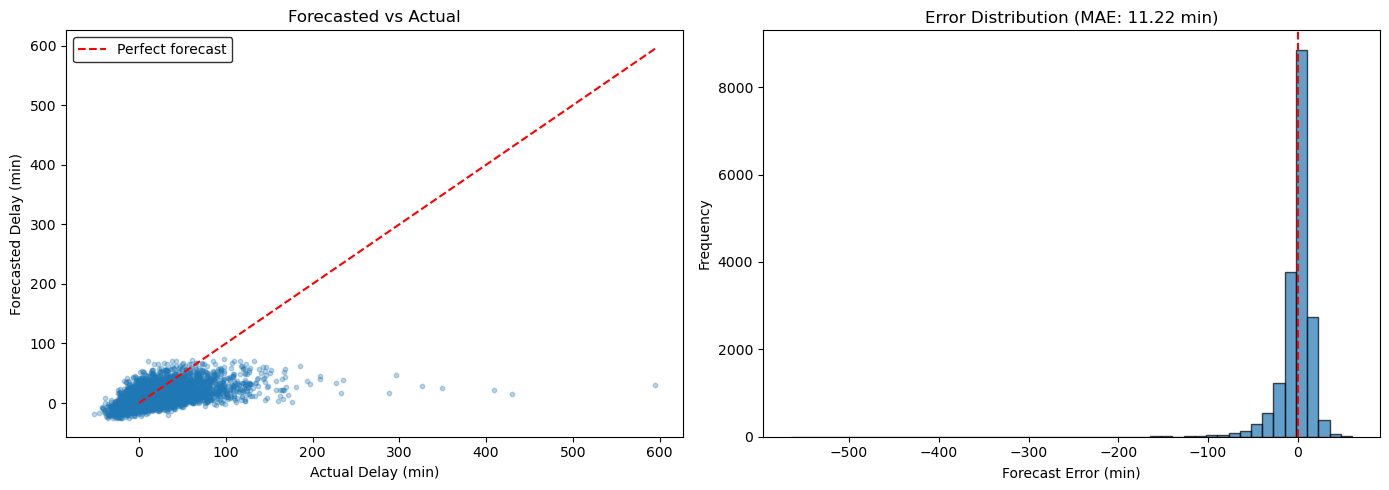

In [9]:
# scatter plot + error histogram side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_pred, alpha=0.3, s=10)
max_val = max(y_test.max(), y_pred.max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect forecast')
ax1.set_xlabel('Actual Delay (min)')
ax1.set_ylabel('Forecasted Delay (min)')
ax1.set_title('Forecasted vs Actual')
ax1.legend(frameon=True, edgecolor='black')

errors = y_pred - y_test
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_xlabel('Forecast Error (min)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Error Distribution (MAE: {metrics["mae"]:.2f} min)')

plt.tight_layout()
plt.show()

## Summary

XGBoost and LightGBM are basically identical across every metric, less than 0.1% MAE difference. Not surprising since they're both gradient boosting on the same features. Both were Optuna-tuned independently, so neither had a hyperparameter advantage. Curious to see if deep learning can get close.

**Next:** [06_lstm_model.ipynb](06_lstm_model.ipynb)